In [74]:
import rasterio as rio

import geopandas as gpd
import shapely
import matplotlib.pyplot as plt
from rasterio.windows import bounds as window_bounds, Window
from rasterio.plot import reshape_as_image
from shapely.geometry import box
from pathlib import Path
import cv2
import numpy as np
from affine import Affine
from shapely.ops import transform
import pandas as pd
from tqdm.notebook import tqdm


In [52]:
class RasterIOUtils:
    @staticmethod
    def save_png(arr, arr_path):
        arr_path = str(arr_path)
        assert arr_path.endswith(".png")
        if arr.ndim == 2:
            cv2.imwrite(arr_path, arr, )
        elif arr.ndim == 3:
            cv2.imwrite(arr_path, cv2.cvtColor(arr, cv2.COLOR_RGB2BGR))
        else:
            raise ValueError(f"invalid number of dimensions: {arr.ndim=}")

    @staticmethod
    def read_png(arr_path):
        arr =  cv2.imread(str(arr_path), cv2.IMREAD_ANYCOLOR)
        if arr.ndim == 2:
            return arr
        elif arr.ndim == 3:
            return cv2.cvtColor(arr, cv2.COLOR_BGR2RGB)
        else:
            raise ValueError(f"invalid number of dimensions: {arr.ndim=}")


In [53]:
from pydantic import BaseModel, ConfigDict


class CropConfig(BaseModel):
    src: rio.DatasetReader
    gdf: gpd.GeoDataFrame
    window: rio.windows.Window
    
    model_config = ConfigDict(arbitrary_types_allowed=True)



def world_geom_to_window_pixels(geom, world_to_full_pixel, col_off, row_off):
    def _to_px(x, y, z=None):
        col, row = world_to_full_pixel * (x, y)
        return col - col_off, row - row_off
    return transform(_to_px, geom)
        
class CropRasterUtils:
    @staticmethod
    def crop_window_x(src, window):
        arr = src.read(window=window)
        arr = reshape_as_image(arr=arr[:3])
        return arr    
    
    @staticmethod
    def _create_polygons_intersected_with_window(gdf, src, window):
        window_geom = box(*window_bounds(window, src.transform))

        # Fast spatial index query
        candidate_idx = list(gdf.sindex.intersection(window_geom.bounds))
        gdf_candidates = gdf.iloc[candidate_idx]

        # Precise intersection filter (geometry vs window polygon)
        gdf_in_window = gdf_candidates[gdf_candidates.intersects(window_geom)].copy()
        gdf_clipped = gdf_in_window.copy()
        gdf_clipped["geometry"] = gdf_clipped.geometry.intersection(window_geom)


        full_transform = src.transform         # maps pixel -> world
        world_to_full_pixel = ~full_transform # invert: world -> pixel
        col_off, row_off = window.col_off, window.row_off

        gdf_window_px = gdf_clipped.copy()
        gdf_window_px["geometry"] = gdf_window_px.geometry.apply(lambda row: world_geom_to_window_pixels(row, 
                                                                                                         col_off=col_off, 
                                                                                                         row_off=row_off,
                                                                                                         world_to_full_pixel=world_to_full_pixel))
        return gdf_window_px
    
    @staticmethod
    def _create_mask_from_polygons(gdf, mask_height, mask_width):
        mask = np.zeros((mask_height, mask_width), dtype=np.uint8)
        for geom in gdf.geometry:
            if geom.is_empty:
                continue
            if geom.geom_type ==  "Polygon":
                geom = [geom]
            elif geom.geom_type ==  "MultiPolygon":
                geom = list(geom.geoms)
            for geo in geom:
                exterior = np.array(geo.exterior.coords, dtype=np.int32)
                mask = cv2.fillPoly(mask, [exterior], (1))
        return mask
    
    @staticmethod
    def crop_window_y(gdf, src, window):
        gdf_window_px = CropRasterUtils._create_polygons_intersected_with_window(gdf, src, window)
        mask = CropRasterUtils._create_mask_from_polygons(gdf_window_px, 
                                                     mask_height=window.height, 
                                                     mask_width=window.width)
        
        return mask        

    @staticmethod
    def process(crop_config: CropConfig):
        x = CropRasterUtils.crop_window_x(src=crop_config.src, 
                                     window=crop_config.window)
        y = CropRasterUtils.crop_window_y(src=crop_config.src, 
                                     gdf=crop_config.gdf,
                                     window=crop_config.window)
        
        
        return x, y
        
        

In [54]:
# with rio.open("/Users/danylo_kunyk/Desktop/africa/data/ai-challenge/test/2d35f1/2d35f1.tif") as src:
#     meta = src.meta
#     data = src.read()

# gdf = gpd.read_file("/Users/danylo_kunyk/Desktop/africa/data/ai-challenge/test/2d35f1/2d35f1.tif")
# crop_config = CropConfig(
#     src:
# )

In [55]:
class Worker:
    @staticmethod
    def process(tif_path, labels_path, horizontal_step: int, vertical_step: int, output_dir: str):
        gdf = gpd.read_file(labels_path)
        
        processed_windows = []
        error_configs = []
        with rio.open(tif_path) as src:
            gdf = gdf.to_crs(src.crs)
            meta = src.meta
                
            for horizontal_step_id in tqdm(range(meta['width'] // horizontal_step), desc = str((tif_path.parent.name, tif_path.parent.parent.name))):
                for vertical_step_id in range(meta['height'] // vertical_step):
                    x_start, y_start = horizontal_step * horizontal_step_id, vertical_step * vertical_step_id
                    x_path = output_dir / f"x_{horizontal_step_id=}_{vertical_step_id=}.png"
                    y_path = output_dir / f"y_{horizontal_step_id=}_{vertical_step_id=}.png"
                    if x_path.exists() and y_path.exists():
                        continue
                        
                    crop_config = CropConfig(
                        src=src,
                        gdf=gdf,
                        window=Window(x_start, y_start, horizontal_step, vertical_step)
                    )
                    try:
                        x, y = CropRasterUtils.process(
                            crop_config=crop_config
                        )
                        if np.all(y == 0):
                            continue
                        
                        RasterIOUtils.save_png(
                            x,
                            arr_path=x_path
                        )
                        RasterIOUtils.save_png(
                            y,
                            arr_path=y_path 
                        )
                        processed_windows.append(dict(
                            window=dict(crop_config.window.todict()),
                            x_path=str(x_path),
                            y_path=str(y_path)
                            ))
                    except:
                        error_configs.append(dict(
                            window=dict(crop_config.window.todict()),
                            tif_path = str(tif_path),
                            labels_path = str(labels_path)
                        ))
                        continue

        return pd.DataFrame(processed_windows), error_configs
            

In [63]:
import shutil

HORIZONTAL_STEP = 1024
VERTICAL_STEP = 1024



split_dir = Path("/workspace/data/raw/train_tier_2")

output_dir = Path("/workspace/data/new_processed/tier_2/")


# shutil.rmtree(output_dir, ignore_errors=True)
output_dir.mkdir(parents=True, exist_ok=True)


res = []
tier1_error_configs = []
for city_path in reversed(list(split_dir.glob("*"))):
    if not city_path.is_dir():
        continue
    for chunk_path in (city_path.glob("*")):
        if (not chunk_path.is_dir()) or chunk_path.name.endswith("-labels") or chunk_path.name.startswith(".DS_Store"):
            continue
        tif_path = chunk_path / f"{chunk_path.name}.tif"
        labels_path = chunk_path.with_stem(f"{chunk_path.name}-labels") / f"{chunk_path.name}.geojson"


        chunk_output_dir = output_dir / city_path.name / chunk_path.name 
        chunk_output_dir.mkdir(exist_ok=True, parents=True)
        
        resulting_df, errs = Worker.process(tif_path, labels_path, 
                                      horizontal_step=HORIZONTAL_STEP,
                                        vertical_step=VERTICAL_STEP, 
                                        output_dir=chunk_output_dir)
        resulting_df['tif_path'] = tif_path
        resulting_df['labels_path'] = labels_path

        resulting_df['chunk_id'] = tif_path.parent.name
        resulting_df['city_id'] = tif_path.parent.parent.name
        res.append(resulting_df)
        tier1_error_configs.extend(errs)


('0ccd08', 'dar'):   0%|          | 0/49 [00:00<?, ?it/s]

('109874', 'dar'):   0%|          | 0/82 [00:00<?, ?it/s]

('1d8af6', 'dar'):   0%|          | 0/48 [00:00<?, ?it/s]

('219237', 'dar'):   0%|          | 0/84 [00:00<?, ?it/s]

('24a7d8', 'dar'):   0%|          | 0/34 [00:00<?, ?it/s]

('385a0e', 'dar'):   0%|          | 0/49 [00:00<?, ?it/s]

('3b3e53', 'dar'):   0%|          | 0/55 [00:00<?, ?it/s]

('541eff', 'dar'):   0%|          | 0/25 [00:00<?, ?it/s]

('56e713', 'dar'):   0%|          | 0/30 [00:00<?, ?it/s]

('5fadcd', 'dar'):   0%|          | 0/76 [00:00<?, ?it/s]

('5fe6fb', 'dar'):   0%|          | 0/47 [00:00<?, ?it/s]

('63c3f9', 'dar'):   0%|          | 0/48 [00:00<?, ?it/s]

('759e34', 'dar'):   0%|          | 0/20 [00:00<?, ?it/s]

('82a1f3', 'dar'):   0%|          | 0/48 [00:00<?, ?it/s]

('8737a8', 'dar'):   0%|          | 0/46 [00:00<?, ?it/s]

('8d7dd4', 'dar'):   0%|          | 0/37 [00:00<?, ?it/s]

('94a004', 'dar'):   0%|          | 0/145 [00:00<?, ?it/s]

('97ce35', 'dar'):   0%|          | 0/34 [00:00<?, ?it/s]

('9870ba', 'dar'):   0%|          | 0/36 [00:00<?, ?it/s]

('ab32c9', 'dar'):   0%|          | 0/67 [00:00<?, ?it/s]

('b8faa3', 'dar'):   0%|          | 0/30 [00:00<?, ?it/s]

('c533fa', 'dar'):   0%|          | 0/50 [00:00<?, ?it/s]

('ca3445', 'dar'):   0%|          | 0/47 [00:00<?, ?it/s]

('cbf72d', 'dar'):   0%|          | 0/38 [00:00<?, ?it/s]

('cf83de', 'dar'):   0%|          | 0/46 [00:00<?, ?it/s]

('d2f2f4', 'dar'):   0%|          | 0/56 [00:00<?, ?it/s]

('e14d1d', 'dar'):   0%|          | 0/28 [00:00<?, ?it/s]

('eadfa3', 'dar'):   0%|          | 0/50 [00:00<?, ?it/s]

('ef8f27', 'dar'):   0%|          | 0/49 [00:00<?, ?it/s]

('f9d120', 'dar'):   0%|          | 0/78 [00:00<?, ?it/s]

/opt/conda/envs/main_11/lib/python3.11/site-packages/pyogrio/raw.py:200: RuntimeWarning: Several features with id = 1 have been found. Altering it to be unique. This warning will not be emitted anymore for this layer
  return ogr_read(


('fb4c1a', 'dar'):   0%|          | 0/72 [00:00<?, ?it/s]

('240168', 'mah'):   0%|          | 0/33 [00:00<?, ?it/s]

('5fe2d3', 'mah'):   0%|          | 0/29 [00:00<?, ?it/s]

('71e6c2', 'mah'):   0%|          | 0/51 [00:00<?, ?it/s]

('bd129c', 'mah'):   0%|          | 0/37 [00:00<?, ?it/s]

('4f38e1', 'gao'):   0%|          | 0/55 [00:00<?, ?it/s]

('048ffb', 'gao'):   0%|          | 0/60 [00:00<?, ?it/s]

('10d200', 'kin'):   0%|          | 0/7 [00:00<?, ?it/s]

('255028', 'kin'):   0%|          | 0/3 [00:00<?, ?it/s]

('982a1f', 'nia'):   0%|          | 0/19 [00:00<?, ?it/s]

('b80615', 'nia'):   0%|          | 0/17 [00:00<?, ?it/s]

In [7]:

full_resulting_df = pd.concat(res).reset_index(drop=True)
full_resulting_df.to_csv(output_dir / 'dataset.csv')

In [ ]:
import shutil

HORIZONTAL_STEP = 1024
VERTICAL_STEP = 1024



split_dir = Path("/home/ec2-user/SageMaker/africa/data/ai-challenge/train_tier_2")

output_dir = Path("/home/ec2-user/SageMaker/africa/data/datasets/tier_2/")


# shutil.rmtree(output_dir, ignore_errors=True)
output_dir.mkdir(parents=True, exist_ok=True)


res = []
tier2_error_configs = []

for city_path in split_dir.glob("*"):
    if not city_path.is_dir():
        continue
    for chunk_path in city_path.glob("*"):
        if (not chunk_path.is_dir()) or chunk_path.name.endswith("-labels") or chunk_path.name.startswith(".DS_Store"):
            continue
        tif_path = chunk_path / f"{chunk_path.name}.tif"
        labels_path = chunk_path.with_stem(f"{chunk_path.name}-labels") / f"{chunk_path.name}.geojson"


        chunk_output_dir = output_dir / city_path.name / chunk_path.name 
        chunk_output_dir.mkdir(exist_ok=True, parents=True)
        
        resulting_df, errs = Worker.process(tif_path, labels_path, 
                                      horizontal_step=HORIZONTAL_STEP,
                                        vertical_step=VERTICAL_STEP, 
                                        output_dir=chunk_output_dir)
        resulting_df['tif_path'] = tif_path
        resulting_df['labels_path'] = labels_path

        resulting_df['chunk_id'] = tif_path.parent.name
        resulting_df['city_id'] = tif_path.parent.parent.name
        res.append(resulting_df)
        tier2_error_configs.extend(errs)

full_resulting_df = pd.concat(resulting_df).reset_index(drop=True)
full_resulting_df.to_csv(output_dir / 'dataset.csv')

('240168', 'mah'):   0%|          | 0/33 [00:00<?, ?it/s]

('5fe2d3', 'mah'):   0%|          | 0/29 [00:00<?, ?it/s]

('71e6c2', 'mah'):   0%|          | 0/51 [00:00<?, ?it/s]

('bd129c', 'mah'):   0%|          | 0/37 [00:00<?, ?it/s]

('4f38e1', 'gao'):   0%|          | 0/55 [00:00<?, ?it/s]

('048ffb', 'gao'):   0%|          | 0/60 [00:00<?, ?it/s]

('255028', 'kin'):   0%|          | 0/3 [00:00<?, ?it/s]

('10d200', 'kin'):   0%|          | 0/7 [00:00<?, ?it/s]

('ef8f27', 'dar'):   0%|          | 0/49 [00:00<?, ?it/s]

('97ce35', 'dar'):   0%|          | 0/34 [00:00<?, ?it/s]

('82a1f3', 'dar'):   0%|          | 0/48 [00:00<?, ?it/s]

('1d8af6', 'dar'):   0%|          | 0/48 [00:00<?, ?it/s]

('385a0e', 'dar'):   0%|          | 0/49 [00:00<?, ?it/s]

('94a004', 'dar'):   0%|          | 0/145 [00:00<?, ?it/s]

('eadfa3', 'dar'):   0%|          | 0/50 [00:00<?, ?it/s]

('5fadcd', 'dar'):   0%|          | 0/76 [00:00<?, ?it/s]

('24a7d8', 'dar'):   0%|          | 0/34 [00:00<?, ?it/s]

('759e34', 'dar'):   0%|          | 0/20 [00:00<?, ?it/s]

('219237', 'dar'):   0%|          | 0/84 [00:00<?, ?it/s]

('8737a8', 'dar'):   0%|          | 0/46 [00:00<?, ?it/s]

In [ ]:

full_resulting_df = pd.concat(res).reset_index(drop=True)
full_resulting_df.to_csv(output_dir / 'dataset.csv')

In [ ]:
import json
with open('tier1_errors.json', 'w') as f:
    json.dump(tier1_error_configs, f)

with open('tier2_errors.json', 'w') as f:
    json.dump(tier2_error_configs, f)

In [ ]:
import json
import urllib.request
import boto3

# 1. Get region from instance metadata
def get_region():
    url = "http://169.254.169.254/latest/dynamic/instance-identity/document"
    with urllib.request.urlopen(url, timeout=2) as resp:
        doc = json.loads(resp.read().decode())
    return doc["region"]

# 2. Get notebook instance name from the environment file SageMaker writes
def get_notebook_instance_name():
    # This file is present on SageMaker notebook instances
    with open("/opt/ml/metadata/resource-metadata.json") as f:
        meta = json.load(f)
    return meta["ResourceName"]

region = get_region()
instance_name = get_notebook_instance_name()

print("Region:", region)
print("Notebook instance:", instance_name)

# 3. Stop this notebook instance using SageMaker API
sm = boto3.client("sagemaker", region_name=region)
response = sm.stop_notebook_instance(NotebookInstanceName=instance_name)
print("Stop requested:", response)


In [ ]:
# split_dir = Path("/home/ec2-user/SageMaker/africa/data/ai-challenge/train_tier_1")

output_dir = Path("/workspace/data/new_processed/tier_1/")


output_dir.mkdir(parents=True, exist_ok=True)


res = []

for city_path in tqdm(output_dir.glob("*")):
    if not city_path.is_dir():
        continue

    for chunk_path in (city_path.glob("*")):
        if not chunk_path.is_dir():
            continue
        for x_path in tqdm(chunk_path.glob("x_*.png")):
            y_path = x_path.parent / x_path.name.replace('x_', 'y_')

            if x_path.exists() and y_path.exists():
                res.append({"x_path": x_path, "y_path": y_path})
            
            # else:
            #     print( x_path.exists(), y_path.exists(), x_path,  y_path)

            


    
    
res_df = pd.DataFrame(res)


res_df['chunk'] = res_df['x_path'].map(lambda x: Path(x).parent.name)
res_df['city'] = res_df['y_path'].map(lambda x: Path(x).parent.parent.name)
res_df = res_df[res_df.city == "acc"]
res_df.to_csv(output_dir / 'train.csv')

# res_df['split'] = res_df['city'].map(lambda c: "val" if c in ['znz', 'mon', 'nia'] else "train")

# def make_split(split, output_dir):
#     res_df[res_df['split'] == split].to_csv(output_dir / f"{split}.csv")
    
# make_split("train", output_dir)
# make_split("val", output_dir)


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

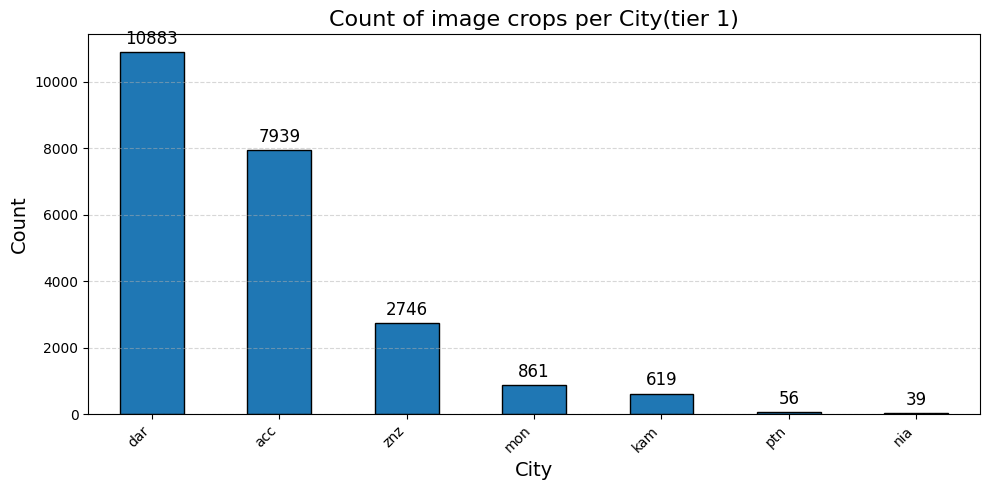

In [71]:
import matplotlib.pyplot as plt

ax = (
    res_df.groupby('city')
          .count()['x_path']
          .sort_values(ascending=False)
          .plot(kind='bar', figsize=(10, 5), edgecolor='black')
)

ax.set_title("Count of image crops per City(tier 1)", fontsize=16)
ax.set_xlabel("City", fontsize=14)
ax.set_ylabel("Count", fontsize=14)
ax.grid(axis='y', linestyle='--', alpha=0.5)

plt.xticks(rotation=45, ha='right')

# ---- Add value labels above bars ----
for p in ax.patches:
    value = int(p.get_height())
    ax.annotate(
        str(value),
        (p.get_x() + p.get_width() / 2, p.get_height()),
        ha='center',
        va='bottom',
        fontsize=12,
        xytext=(0, 3),        # move text slightly up
        textcoords='offset points'
    )

plt.tight_layout()
plt.show()


In [73]:
len(list(Path("/workspace/data/new_processed/tier_2/").glob("*")))

8

In [23]:
res_df

,x_path,y_path,chunk,city,split
0,/home/ec2-user/SageMaker/africa/data/datasets/...,/home/ec2-user/SageMaker/africa/data/datasets/...,aee7fd,znz,train
1,/home/ec2-user/SageMaker/africa/data/datasets/...,/home/ec2-user/SageMaker/africa/data/datasets/...,aee7fd,znz,train
2,/home/ec2-user/SageMaker/africa/data/datasets/...,/home/ec2-user/SageMaker/africa/data/datasets/...,aee7fd,znz,train
3,/home/ec2-user/SageMaker/africa/data/datasets/...,/home/ec2-user/SageMaker/africa/data/datasets/...,aee7fd,znz,train
4,/home/ec2-user/SageMaker/africa/data/datasets/...,/home/ec2-user/SageMaker/africa/data/datasets/...,aee7fd,znz,train
...,...,...,...,...,...
23138,/home/ec2-user/SageMaker/africa/data/datasets/...,/home/ec2-user/SageMaker/africa/data/datasets/...,401175,mon,val
23139,/home/ec2-user/SageMaker/africa/data/datasets/...,/home/ec2-user/SageMaker/africa/data/datasets/...,401175,mon,val
23140,/home/ec2-user/SageMaker/africa/data/datasets/...,/home/ec2-user/SageMaker/africa/data/datasets/...,401175,mon,val
23141,/home/ec2-user/SageMaker/africa/data/datasets/...,/home/ec2-user/SageMaker/africa/data/datasets/...,401175,mon,val


In [ ]:
from src.dataset.preprocess_tier2_data import batch_process_tier2_data

results = batch_process_tier2_data(
    images_dir=Path("/workspace/data/new_processed/tier_2/"),
    predicted_masks_dir=Path("/workspace/data/predicted_best/tier_2/"),
    gt_masks_dir=Path("/workspace/data/new_processed/tier_2/"),  
    output_dir=Path("/workspace/data/refined_tier2"),
    iou_threshold=0.7,
    extract_crops=True,
    min_area=50,
    image_extension=".png",
    verbose=True
)

print(f"Processed {results['summary']['successful']} images successfully")
print(f"Extracted {results['summary']['total_crops_extracted']} crops")